interactive(children=(FloatSlider(value=50.0, description='Pumping rate [m³/h]', layout=Layout(width='420px'),…

<function __main__.plot_drawdown(Q=50, T=200, S=0.1, t=4380, dist=200, rb=5.0)>

Error in callback <function _draw_all_if_interactive at 0x00000284B91A60C0> (for post_execute), with arguments args (),kwargs {}:


ValueError: 'tab:black' is not a valid color value.

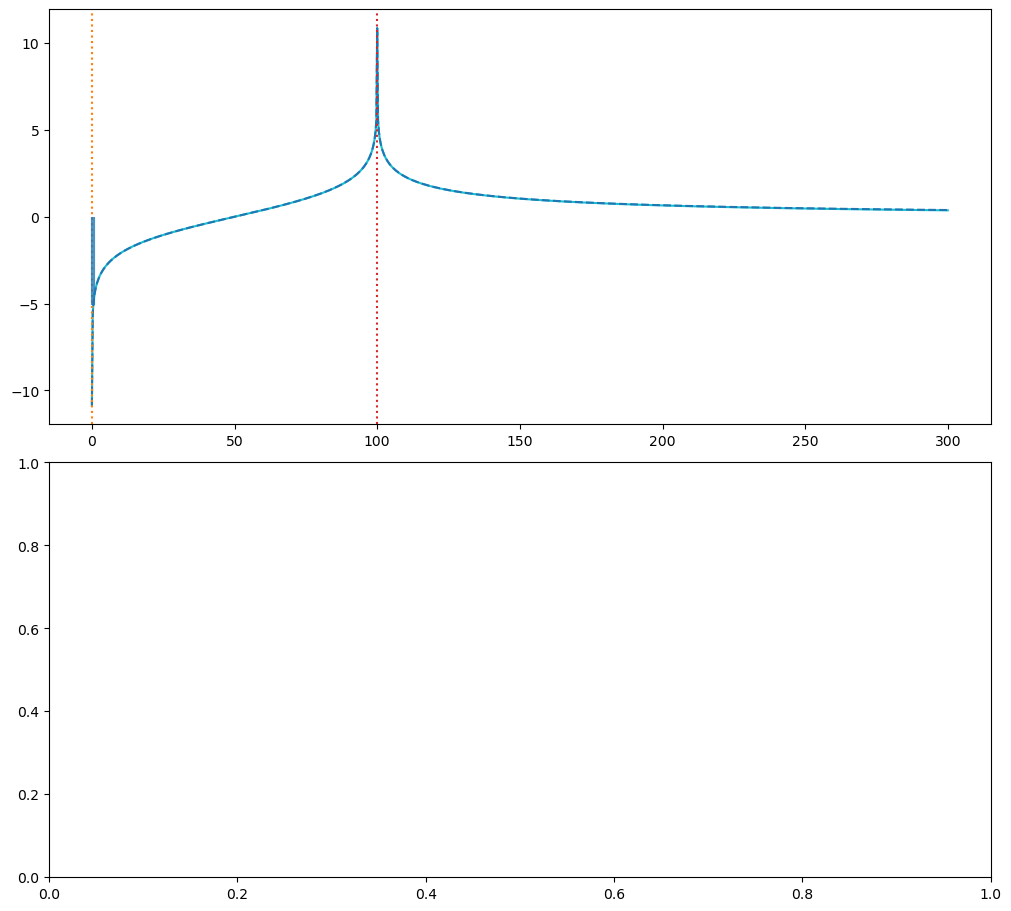

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import exp1
import ipywidgets as widgets
from ipywidgets import interact

EPS = 1e-12  # small number to avoid zero-division or log(0)

def theis_drawdown(Q, r, S, T, t):
    """Vectorized Theis drawdown. Returns np.ndarray or np.nan."""
    if np.any(T <= 0) or np.any(t <= 0):
        return np.nan
    denom = 4 * T * t + EPS
    u = (r**2 * S) / denom
    u = np.maximum(u, EPS)  # avoid passing 0 into exp1
    s = (Q / (4 * np.pi * T)) * exp1(u)
    return s

def cooper_jacob_drawdown(Q, r, S, T, t):
    """Vectorized Cooper–Jacob late-time approximation."""
    if np.any(T <= 0) or np.any(t <= 0):
        return np.nan
    denom = 4 * T * t + EPS
    u = (r**2 * S) / denom
    u = np.maximum(u, EPS)  # avoid log(0)
    s = (Q / (4 * np.pi * T)) * (-0.5772156649015329 - np.log(u))
    return s

max_dist = 300

def plot_drawdown(Q=50, T=200, S=0.1, t=4380, dist=200, rb=5.0):
    # unit conversions
    t = t * 3600       # h -> s
    T = T / 86400      # m²/d -> m²/s
    Q = Q / 3600       # m³/h -> m³/s

    n_disc = 1000
    x = np.linspace(0, max_dist, n_disc)
    r_ex = np.abs(x)            # distance to extraction well at x=0
    r_in = np.abs(x - dist)     # distance to injection well at x=dist

    # superposition: extraction (negative Q) + injection (positive Q)
    draw_theis = theis_drawdown(-Q, r_ex, S, T, t) + theis_drawdown(Q, r_in, S, T, t)
    draw_cooja = cooper_jacob_drawdown(-Q, r_ex, S, T, t) + cooper_jacob_drawdown(Q, r_in, S, T, t)

    # value at the well boundary position rb (interpolated)
    rb = float(np.clip(rb, 0.0, max_dist))
    y_rb = np.interp(rb, x, draw_theis if np.ndim(draw_theis) else np.array([np.nan]))

   # colors
    color_theis = "tab:cyan"
    color_cooja = "tab:blue"
    color_extraction = "tab:orange"
    color_injection = "tab:red" 
    color_boundary = "tab:black"

    # figure with two stacked subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 9), sharey=False, constrained_layout=True)

    # --- top: full domain ---
    ax1.plot(x, draw_theis, label='Theis', color=color_theis)
    ax1.plot(x, draw_cooja, label='Cooper–Jacob', linestyle='--', color=color_cooja)
    ax1.axvline(0, linestyle=':', label='Extraction well', color=color_extraction)
    ax1.axvline(dist, linestyle=':', label='Injection well', color=color_injection)

    # vertical "bar" at well boundary from y=0 to y=y_rb
    ymin, ymax = (0.0, y_rb) if y_rb >= 0 else (y_rb, 0.0)
    ax1.vlines(rb, ymin, ymax, linewidth=3, alpha=0.8, label=f'Well boundary @ {rb:.2f} m')
    ax1.scatter([rb], [y_rb], zorder=3)

    ax1.set_xlabel('Position [m]')
    ax1.set_ylabel('Drawdown [m]')
    ax1.set_title('Aquifer surface level (full domain)')
    ax1.grid(True)
    ax1.legend()

    # --- bottom: zoom near extraction well ---
    ax2.plot(x, draw_theis, label='Theis', color=color_theis)
    ax2.plot(x, draw_cooja, label='Cooper–Jacob', linestyle='--', color=color_cooja)
    ax2.axvline(0, linestyle=':', label='Extraction well', color=color_extraction)
    x_zoom = 3.0
    # show boundary bar here too if it lies within zoom window
    if rb <= x_zoom:
        ax2.vlines(rb, ymin, ymax, linewidth=3, alpha=0.8, label=f'Well boundary @ {rb:.2f} m')
        ax2.scatter([rb], [y_rb], zorder=3)

    ax2.set_xlim(0, max(1e-6, float(x_zoom)))
    # make the y-range a tight-ish view around local data near 0..x_zoom
    mask_zoom = (x <= x_zoom)
    if np.any(mask_zoom):
        y_zoom_vals = np.concatenate([np.atleast_1d(draw_theis[mask_zoom]), np.atleast_1d(draw_cooja[mask_zoom])])
        if np.all(np.isfinite(y_zoom_vals)):
            pad = 0.05 * (y_zoom_vals.max() - y_zoom_vals.min() + EPS)
            ax2.set_ylim(y_zoom_vals.min() - pad, y_zoom_vals.max() + pad)

    ax2.set_xlabel('Position [m]')
    ax2.set_ylabel('Drawdown [m]')
    ax2.set_title('Zoom near extraction well')
    ax2.grid(True)
    ax2.legend()

    plt.show()

def format_label(description, unit=None):
    return f'{description} [{unit}]' if unit else description

style = {'description_width': '200px'}
layout = widgets.Layout(width='420px')

interact(
    plot_drawdown,
    Q=widgets.FloatSlider(value=50, min=1, max=200, step=1,
                          description=format_label('Pumping rate', 'm³/h'), style=style, layout=layout),
    T=widgets.FloatSlider(value=200, min=10, max=1000, step=10,
                          description=format_label('Transmissivity', 'm²/d'), style=style, layout=layout),
    S=widgets.FloatSlider(value=0.1, min=0.01, max=1, step=0.01,
                          description=format_label('Storativity'), style=style, layout=layout),
    t=widgets.FloatSlider(value=4000, min=1, max=8761, step=24,
                          description=format_label('Pumping duration', 'h'), style=style, layout=layout),
    dist=widgets.FloatSlider(value=100, min=10, max=max_dist, step=10,
                             description=format_label('Well distance', 'm'), style=style, layout=layout),
    rb=widgets.FloatSlider(value=0.5, min=0.1, max=2.0, step=0.1,
                           description=format_label('Well radius', 'm'), style=style, layout=layout),
)